# Physical Beamformer testing

In [544]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pyroomacoustics as pra
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)
from scipy.io import wavfile
from scipy.signal import resample
from playsound import playsound
from os import listdir
from os.path import isfile, join

### Build Anechoic Simulation Room

In [545]:
fs = 48000 # audio sampling frequency - global (set to freq of input file)

room_x = 10 # stage width
room_y = 10 # room length
order = 0 # reflection order
sigma2_n = 5e-7 # microphone noise variance estimate
v_sound = 343.0 # speed of sound in air

m = pra.make_materials(
    ceiling="hard_surface",
    floor="stage_floor",
    east="brickwork",
    west="brickwork",
    north="brickwork",
    south="brickwork",
) # materials of each surface of room, defines signal absorption

room = pra.ShoeBox([room_x, room_y], fs=fs, materials=m, max_order=order, air_absorption=True, ray_tracing=False)

### Place mics

In [546]:
# design parameters of array
array_loc = [5, 0.1] # x/y location of array center
n_mics = 8 # number of microphones
sep = 0.3 # microphone separation

N = 1024 # fft length - defines N/2 + 1 frequency bands

R = pra.linear_2D_array(center=array_loc, M=n_mics, phi=0, d=sep)
mic_array = pra.Beamformer(R, room.fs, N) # uses omnidirectional mics by default
room.add_microphone_array(mic_array)

### Load Recorded Signals

Stores them in microphone objects

In [547]:
mic_signals_folder = '../array_samples/y=2,x=1_twosource_3'
mic_signals_filenames = [f for f in listdir(mic_signals_folder) if isfile(join(mic_signals_folder, f))]
mic_signals_filenames.sort()

for i in range(n_mics):
    file_str = mic_signals_folder + '/' + mic_signals_filenames[i]
    rate, audio = wavfile.read(file_str)

    # ensure sampling rates of all audio matches
    if rate != fs:
        num_samples = int(len(audio) * fs / rate)
        audio = resample(audio, num_samples)

    if i == 0:
        mic_signals = np.zeros((n_mics, len(audio)))

    mic_signals[n_mics-1-i, :] = audio

room.mic_array.signals = mic_signals

/var/folders/_f/h8xwd2k15l36zgym21rpns740000gn/T/ipykernel_48653/1786311218.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, audio = wavfile.read(file_str)


In [548]:
# compute noise covariance matrix
room_signals_folder = '../array_samples/twosource_room'
room_signals_filenames = [f for f in listdir(room_signals_folder) if isfile(join(room_signals_folder, f))]
room_signals_filenames.sort()

for i in range(n_mics):
    file_str = room_signals_folder + '/' + room_signals_filenames[i]
    rate, audio = wavfile.read(file_str)

    # ensure sampling rates of all audio matches
    if rate != fs:
        num_samples = int(len(audio) * fs / rate)
        audio = resample(audio, num_samples)

    if i == 0:
        room_signals = np.zeros((n_mics, len(audio)))

    room_signals[n_mics-1-i, :] = audio

snapshot = room_signals[:, :]

diag_loading = 0 # ensures nonzero eigenvalues
R_n = (1.0/snapshot.shape[1]) * np.cov(snapshot) + diag_loading * (np.eye(n_mics))
print(R_n)

[[20654616.67361348 20853777.35752959 -1806615.68615707  4434510.54805085
  17098811.67104688 17176958.74636023  7569512.09324695 11088844.48604913]
 [20853777.35752959 24254335.6018059  -3170560.9428739   4274536.40960728
  19087873.08377382 19476884.58633859  7633524.78225087 13069792.12077625]
 [-1806615.68615707 -3170560.9428739   1932154.73639526    76418.01201197
  -2172365.98675381 -2299102.04576704  1209572.20645598  -747224.8825734 ]
 [ 4434510.54805085  4274536.40960728    76418.01201197  1147460.76092441
   3644878.83984727  3639996.18505778  2326827.66914054  2627741.64885794]
 [17098811.67104688 19087873.08377382 -2172365.98675381  3644878.83984727
  15379137.22296358 15600003.06103821  6727424.5103848  10471425.01964006]
 [17176958.74636023 19476884.58633859 -2299102.04576704  3639996.18505778
  15600003.06103821 15942467.3266899   6927256.38703477 10792236.44595378]
 [ 7569512.09324695  7633524.78225087  1209572.20645598  2326827.66914054
   6727424.5103848   6927256.387

/var/folders/_f/h8xwd2k15l36zgym21rpns740000gn/T/ipykernel_48653/4130779679.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, audio = wavfile.read(file_str)


### Isolate sources with beamforming

In [549]:
# add guessed locations of sources to room
n_source = 2
doa_azimuths = np.array([np.arctan2(2,1), np.arctan2(2,-1)]) # ground truth
# doa_azimuths = np.array([55.86206897, 93.10344828])*np.pi/180.0 # DOA estimate

# add guessed locations of sources to room
guess_dist = 3 # guessed distance away from array - choose far distance for precise beam
guess_source_locs = np.empty((2, n_source))

for i in range(n_source):
    guess_source_locs[0, i] = array_loc[0] + guess_dist*np.cos(doa_azimuths[i])
    guess_source_locs[1, i] = array_loc[1] + guess_dist*np.sin(doa_azimuths[i])

# Beamforming algorithm for each source
out_filepath = '../output_samples/physical_tests'

for i in range(guess_source_locs.shape[1]):
    current_interferers = guess_source_locs
    current_interferers = np.delete(current_interferers, i, 1)

    interf = pra.soundsource.SoundSource([0, 0])
    interf.images = current_interferers

    source = pra.soundsource.SoundSource([0, 0])
    source.images = np.array([[guess_source_locs[0, i]], [guess_source_locs[1, i]]])

    mic_array.rake_max_sinr_weights(
        source=source,
        interferer=interf,
        R_n=R_n # estimated noise covariance matrix
    )
    mic_array.filters_from_weights() # process with time domain filters for now, can also use FD directly

    # compute SIR, averaged across all frequency bands
    SIR_sum = 0
    for f in mic_array.frequencies:
        current_SIR = mic_array.snr(source, interf, f, dB=True)
        if math.isnan(current_SIR) == False:
            SIR_sum += current_SIR
    SIR_avg = SIR_sum / len(mic_array.frequencies)
    print(f'source {i+1} average SINR: {SIR_avg:.2f}')

    # save processed sound as output
    output = mic_array.process()
    out_norm = pra.normalize(output)
    wavfile.write(out_filepath + '/isolated_src' + str(i+1) + '.wav', fs, out_norm)

source 1 average SINR: 8.95
source 2 average SINR: 8.66


### Evaluate performance

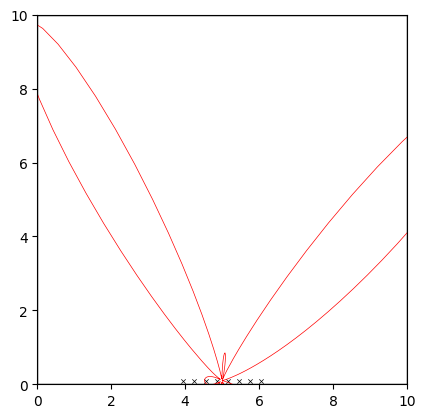

In [550]:
# plot peam pattern
fig, ax = room.plot(freq=[1000], img_order=0)